# Locality Sensitive Hashing


In [8]:
import numpy as np
import graphlab
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import norm
from sklearn.metrics.pairwise import pairwise_distances
import time
from copy import copy
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
wiki = graphlab.SFrame('people_wiki.gl/')

This non-commercial license of GraphLab Create for academic use is assigned to 500077185@stu.upes.ac.in and will expire on April 04, 2021.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\TEJAS\AppData\Local\Temp\graphlab_server_1591027129.log.0


In [10]:
wiki = wiki.add_row_number()
wiki

id,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell> ...,Digby Morrell,digby morrell born 10october 1979 is a former ...
1,<http://dbpedia.org/resource/Alfred_J._Lewy> ...,Alfred J. Lewy,alfred j lewy aka sandylewy graduated from ...
2,<http://dbpedia.org/resource/Harpdog_Brown> ...,Harpdog Brown,harpdog brown is a singerand harmonica player who ...
3,<http://dbpedia.org/resource/Franz_Rottensteiner> ...,Franz Rottensteiner,franz rottensteiner bornin waidmannsfeld lower ...
4,<http://dbpedia.org/resource/G-Enka> ...,G-Enka,henry krvits born 30december 1974 in tallinn ...
5,<http://dbpedia.org/resource/Sam_Henderson> ...,Sam Henderson,sam henderson bornoctober 18 1969 is an ...
6,<http://dbpedia.org/resource/Aaron_LaCrate> ...,Aaron LaCrate,aaron lacrate is anamerican music producer ...
7,<http://dbpedia.org/resource/Trevor_Ferguson> ...,Trevor Ferguson,trevor ferguson aka johnfarrow born 11 november ...
8,<http://dbpedia.org/resource/Grant_Nelson> ...,Grant Nelson,grant nelson born 27april 1971 in london ...
9,<http://dbpedia.org/resource/Cathy_Caruth> ...,Cathy Caruth,cathy caruth born 1955 isfrank h t rhodes ...


## Extract TF-IDF Matrix

In [12]:
wiki['tf_idf'] = graphlab.text_analytics.tf_idf(wiki['text'])
wiki

id,URI,name,text,tf_idf
0,<http://dbpedia.org/resource/Digby_Morrell> ...,Digby Morrell,digby morrell born 10october 1979 is a former ...,"{'since':1.455376717308041, ..."
1,<http://dbpedia.org/resource/Alfred_J._Lewy> ...,Alfred J. Lewy,alfred j lewy aka sandylewy graduated from ...,"{'precise':6.44320060695519, ..."
2,<http://dbpedia.org/resource/Harpdog_Brown> ...,Harpdog Brown,harpdog brown is a singerand harmonica player who ...,"{'just':2.7007299687108643, ..."
3,<http://dbpedia.org/resource/Franz_Rottensteiner> ...,Franz Rottensteiner,franz rottensteiner bornin waidmannsfeld lower ...,"{'all':1.6431112434912472, ..."
4,<http://dbpedia.org/resource/G-Enka> ...,G-Enka,henry krvits born 30december 1974 in tallinn ...,"{'legendary':4.280856294365192, ..."
5,<http://dbpedia.org/resource/Sam_Henderson> ...,Sam Henderson,sam henderson bornoctober 18 1969 is an ...,"{'now': 1.96695239252401,'currently': ..."
6,<http://dbpedia.org/resource/Aaron_LaCrate> ...,Aaron LaCrate,aaron lacrate is anamerican music producer ...,"{'exclusive':10.455187230695827, ..."
7,<http://dbpedia.org/resource/Trevor_Ferguson> ...,Trevor Ferguson,trevor ferguson aka johnfarrow born 11 november ...,"{'taxi':6.0520214560945025, ..."
8,<http://dbpedia.org/resource/Grant_Nelson> ...,Grant Nelson,grant nelson born 27april 1971 in london ...,"{'houston':3.935505942157149, ..."
9,<http://dbpedia.org/resource/Cathy_Caruth> ...,Cathy Caruth,cathy caruth born 1955 isfrank h t rhodes ...,"{'phenomenon':5.750053426395245, ..."


In [13]:
def sframe_to_scipy(column):
   
    # Create triples of (row_id, feature_id, count).
    x = graphlab.SFrame({'X1':column})
    
    # 1. Add a row number.
    x = x.add_row_number()
    # 2. Stack will transform x to have a row for each unique (row, key) pair.
    x = x.stack('X1', ['feature', 'value'])

    # Map words into integers using a OneHotEncoder feature transformation.
    f = graphlab.feature_engineering.OneHotEncoder(features=['feature'])

    # We first fit the transformer using the above data.
    f.fit(x)

    # The transform method will add a new column that is the transformed version
    # of the 'word' column.
    x = f.transform(x)

    # Get the feature mapping.
    mapping = f['feature_encoding']

    # Get the actual word id.
    x['feature_id'] = x['encoded_features'].dict_keys().apply(lambda x: x[0])

    # Create numpy arrays that contain the data for the sparse matrix.
    i = np.array(x['id'])
    j = np.array(x['feature_id'])
    v = np.array(x['value'])
    width = x['id'].max() + 1
    height = x['feature_id'].max() + 1

    # Create a sparse matrix.
    mat = csr_matrix((v, (i, j)), shape=(width, height))

    return mat, mapping

In [14]:
start=time.time()
corpus, mapping = sframe_to_scipy(wiki['tf_idf'])
end=time.time()
print end-start

48.7200000286


In [15]:
assert corpus.shape == (59071, 547979)
print 'Check passed correctly!'

Check passed correctly!


## Train a LSH Model

In [16]:
def generate_random_vectors(num_vector, dim):
    return np.random.randn(dim, num_vector)

In [17]:
np.random.seed(0) # set seed=0 for consistent results
generate_random_vectors(num_vector=3, dim=5)

array([[ 1.76405235,  0.40015721,  0.97873798],
       [ 2.2408932 ,  1.86755799, -0.97727788],
       [ 0.95008842, -0.15135721, -0.10321885],
       [ 0.4105985 ,  0.14404357,  1.45427351],
       [ 0.76103773,  0.12167502,  0.44386323]])

In [18]:
np.random.seed(0)
random_vectors = generate_random_vectors(num_vector=16, dim=547979)
random_vectors.shape

(547979L, 16L)

In [19]:
doc = corpus[0, :] # vector of tf-idf values for document 0
doc.dot(random_vectors[:, 0]) >= 0 # True if positive sign; False if negative sign

array([ True])

In [20]:
doc.dot(random_vectors[:, 1]) >= 0

array([ True])

In [21]:
doc.dot(random_vectors) >= 0 

array([[ True,  True, False, False, False,  True,  True, False,  True,
         True,  True, False, False,  True, False,  True]])

In [22]:
np.array(doc.dot(random_vectors) >= 0, dtype=int)

array([[1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1]])

In [23]:
corpus[0:2].dot(random_vectors) >= 0 

array([[ True,  True, False, False, False,  True,  True, False,  True,
         True,  True, False, False,  True, False,  True],
       [ True, False, False, False,  True,  True, False,  True,  True,
        False,  True, False,  True, False, False,  True]])

In [24]:
corpus.dot(random_vectors) >= 0

array([[ True,  True, False, ...,  True, False,  True],
       [ True, False, False, ..., False, False,  True],
       [False,  True, False, ...,  True, False,  True],
       ...,
       [ True,  True, False, ...,  True,  True,  True],
       [False,  True,  True, ...,  True, False,  True],
       [ True, False,  True, ..., False, False,  True]])

In [25]:
np.arange(15, -1, -1)

array([15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0])

In [26]:
doc = corpus[0, :]  # first document
index_bits = (doc.dot(random_vectors) >= 0)
powers_of_two = (1 << np.arange(15, -1, -1))
print index_bits
print powers_of_two
print index_bits.dot(powers_of_two)

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]]
[32768 16384  8192  4096  2048  1024   512   256   128    64    32    16
     8     4     2     1]
[50917]


In [27]:
index_bits = corpus.dot(random_vectors) >= 0
index_bits.dot(powers_of_two)

array([50917, 36265, 19365, ..., 52983, 27589, 41449])

In [28]:
def train_lsh(data, num_vector=16, seed=None):
    
    dim = corpus.shape[1]
    if seed is not None:
        np.random.seed(seed)
    random_vectors = generate_random_vectors(num_vector, dim)
  
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
  
    table = {}
    
    # Partition data points into bins
    bin_index_bits = (data.dot(random_vectors) >= 0)
  
    # Encode bin index bits into integers
    bin_indices = bin_index_bits.dot(powers_of_two)
    
    # Update `table` so that `table[i]` is the list of document ids with bin index equal to i.
    for data_index, bin_index in enumerate(bin_indices):
        if bin_index not in table:
            # If no list yet exists for this bin, assign the bin an empty list.
            table[bin_index] = [] # YOUR CODE HERE
        # Fetch the list of document ids associated with the bin and add the document id to the end.
        # data_index: document ids
        # append() will add a list of document ids to table dict() with key as bin_index
        table[bin_index].append(data_index) # YOUR CODE HERE

    model = {'data': data,
             'bin_index_bits': bin_index_bits,
             'bin_indices': bin_indices,
             'table': table,
             'random_vectors': random_vectors,
             'num_vector': num_vector}
    
    return model

In [29]:
model = train_lsh(corpus, num_vector=16, seed=143)
table = model['table']
if   0 in table and table[0]   == [39583] and \
   143 in table and table[143] == [19693, 28277, 29776, 30399]:
    print 'Passed!'
else:
    print 'Check your code.'

Passed!


## Inspect Bins


In [30]:
wiki[wiki['name'] == 'Barack Obama']

id,URI,name,text,tf_idf
35817,<http://dbpedia.org/resource/Barack_Obama> ...,Barack Obama,barack hussein obama iibrk husen bm born august ...,"{'operations':3.811771079388818, ..."


In [31]:
model

{'bin_index_bits': array([[ True,  True, False, ..., False,  True,  True],
        [False, False,  True, ..., False, False,  True],
        [ True, False,  True, ..., False, False,  True],
        ...,
        [ True,  True, False, ...,  True,  True, False],
        [ True,  True,  True, ..., False,  True,  True],
        [False, False,  True, ...,  True, False, False]]),
 'bin_indices': array([53003, 10913, 46185, ..., 52070, 62355, 13108]),
 'data': <59071x547979 sparse matrix of type '<type 'numpy.float64'>'
 	with 10379283 stored elements in Compressed Sparse Row format>,
 'num_vector': 16,
 'random_vectors': array([[-0.83315434,  1.23769101, -2.47573104, ...,  0.79756606,
         -0.41435758, -0.24241533],
        [-0.65265148,  0.25670927,  0.40447313, ..., -1.42644501,
         -0.74615805,  0.51974589],
        [ 0.94565582, -0.63795808,  0.61621208, ...,  0.30495995,
         -0.96495193, -0.49425259],
        ...,
        [-0.16295889, -0.73916065, -1.77774722, ..., -0.76420

In [32]:
wiki[wiki['name'] == 'Barack Obama']['id'][0]

35817L

In [33]:
print model['bin_indices'][35817]

50194


In [34]:
wiki[wiki['name'] == 'Joe Biden']

id,URI,name,text,tf_idf
24478,<http://dbpedia.org/resource/Joe_Biden> ...,Joe Biden,joseph robinette joebiden jr dosf rbnt badn ...,"{'delaware':11.396456717061318, ..."


In [35]:
wiki[wiki['name'] == 'Joe Biden']['id'][0]

24478L

In [36]:
print np.array(model['bin_index_bits'][24478], dtype=int) # list of 0/1's

# bit representations of the bins containing Joe Biden
print model['bin_indices'][24478]

[1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0]
33794


In [37]:
model['bin_index_bits'][35817] == model['bin_index_bits'][24478]


array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True])

In [38]:
wiki[wiki['name']=='Wynn Normington Hugh-Jones']

id,URI,name,text,tf_idf
22745,<http://dbpedia.org/resource/Wynn_Normington_H ...,Wynn Normington Hugh-Jones ...,sir wynn normingtonhughjones kb sometimes ...,"{'forced':3.919175540571719, ..."


In [39]:
print np.array(model['bin_index_bits'][22745], dtype=int) # list of 0/1's
print model['bin_indices'][22745] # integer format
model['bin_index_bits'][35817] == model['bin_index_bits'][22745]

[0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0]
4660


array([False, False,  True, False,  True, False, False,  True,  True,
        True, False,  True,  True, False, False,  True])

In [40]:
model['table'][model['bin_indices'][35817]]

[21426, 35817, 39426, 50261, 53937]

In [41]:
doc_ids = list(model['table'][model['bin_indices'][35817]])
doc_ids.remove(35817) # display documents other than Obama

docs = wiki.filter_by(values=doc_ids, column_name='id') # filter by id column
docs

id,URI,name,text,tf_idf
21426,<http://dbpedia.org/resource/Mark_Boulware> ...,Mark Boulware,mark boulware born 1948is an american diplomat ...,"{'ambassador':15.90834582606623, ..."
39426,<http://dbpedia.org/resource/John_Wells_(polit ...,John Wells (politician),sir john julius wellsborn 30 march 1925 is a ...,"{'when':1.3806055739282235, ..."
50261,<http://dbpedia.org/resource/Francis_Longstaff> ...,Francis Longstaff,francis a longstaff bornaugust 3 1956 is an ...,"{'all':1.6431112434912472, ..."
53937,<http://dbpedia.org/resource/Madurai_T._Sriniv ...,Madurai T. Srinivasan,maduraitsrinivasan is awellknown figure in the ...,"{'alarmelu':21.972990778450388, ..."


In [43]:

def cosine_distance(x, y):
    xy = x.dot(y.T)
    dist = xy/(norm(x)*norm(y))
    return 1-dist[0,0]

obama_tf_idf = corpus[35817,:]
biden_tf_idf = corpus[24478,:]

print '================= Cosine distance from Barack Obama'
print 'Barack Obama - {0:24s}: {1:f}'.format('Joe Biden',
                                             cosine_distance(obama_tf_idf, biden_tf_idf))
for doc_id in doc_ids:
    doc_tf_idf = corpus[doc_id,:]
    print 'Barack Obama - {0:24s}: {1:f}'.format(wiki[doc_id]['name'],
                                                 cosine_distance(obama_tf_idf, doc_tf_idf))

================= Cosine distance from Barack Obama
Barack Obama - Joe Biden               : 0.703139
Barack Obama - Mark Boulware           : 0.950867
Barack Obama - John Wells (politician) : 0.975966
Barack Obama - Francis Longstaff       : 0.978256
Barack Obama - Madurai T. Srinivasan   : 0.993092


## Query the LSH Model

In [44]:
from itertools import combinations

In [45]:
num_vector = 16
search_radius = 3

for diff in combinations(range(num_vector), search_radius):
    print diff

(0, 1, 2)
(0, 1, 3)
(0, 1, 4)
(0, 1, 5)
(0, 1, 6)
(0, 1, 7)
(0, 1, 8)
(0, 1, 9)
(0, 1, 10)
(0, 1, 11)
(0, 1, 12)
(0, 1, 13)
(0, 1, 14)
(0, 1, 15)
(0, 2, 3)
(0, 2, 4)
(0, 2, 5)
(0, 2, 6)
(0, 2, 7)
(0, 2, 8)
(0, 2, 9)
(0, 2, 10)
(0, 2, 11)
(0, 2, 12)
(0, 2, 13)
(0, 2, 14)
(0, 2, 15)
(0, 3, 4)
(0, 3, 5)
(0, 3, 6)
(0, 3, 7)
(0, 3, 8)
(0, 3, 9)
(0, 3, 10)
(0, 3, 11)
(0, 3, 12)
(0, 3, 13)
(0, 3, 14)
(0, 3, 15)
(0, 4, 5)
(0, 4, 6)
(0, 4, 7)
(0, 4, 8)
(0, 4, 9)
(0, 4, 10)
(0, 4, 11)
(0, 4, 12)
(0, 4, 13)
(0, 4, 14)
(0, 4, 15)
(0, 5, 6)
(0, 5, 7)
(0, 5, 8)
(0, 5, 9)
(0, 5, 10)
(0, 5, 11)
(0, 5, 12)
(0, 5, 13)
(0, 5, 14)
(0, 5, 15)
(0, 6, 7)
(0, 6, 8)
(0, 6, 9)
(0, 6, 10)
(0, 6, 11)
(0, 6, 12)
(0, 6, 13)
(0, 6, 14)
(0, 6, 15)
(0, 7, 8)
(0, 7, 9)
(0, 7, 10)
(0, 7, 11)
(0, 7, 12)
(0, 7, 13)
(0, 7, 14)
(0, 7, 15)
(0, 8, 9)
(0, 8, 10)
(0, 8, 11)
(0, 8, 12)
(0, 8, 13)
(0, 8, 14)
(0, 8, 15)
(0, 9, 10)
(0, 9, 11)
(0, 9, 12)
(0, 9, 13)
(0, 9, 14)
(0, 9, 15)
(0, 10, 11)
(0, 10, 12)
(0, 10, 13)
(0, 10, 14

In [46]:
def search_nearby_bins(query_bin_bits, table, search_radius=2, initial_candidates=set()):
    """
    For a given query vector and trained LSH model, return all candidate neighbors for
    the query among all bins within the given search radius.
    
    Example usage
    -------------
    >>> model = train_lsh(corpus, num_vector=16, seed=143)
    >>> q = model['bin_index_bits'][0]  # vector for the first document
  
    >>> candidates = search_nearby_bins(q, model['table'])
    """
    num_vector = len(query_bin_bits)
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
    
    # Allow the user to provide an initial set of candidates.
    candidate_set = copy(initial_candidates)
    
    for different_bits in combinations(range(num_vector), search_radius):       
        # Flip the bits (n_1,n_2,...,n_r) of the query bin to produce a new bit vector.
        ## Hint: you can iterate over a tuple like a list
        alternate_bits = copy(query_bin_bits)
        for i in different_bits:
            # Flip the bits
            alternate_bits[i] = ~alternate_bits[i] # YOUR CODE HERE 
        
        # Convert the new bit vector to an integer index
        nearby_bin = alternate_bits.dot(powers_of_two)
        
        # Fetch the list of documents belonging to the bin indexed by the new bit vector.
        # Then add those documents to candidate_set
        # Make sure that the bin exists in the table!
        # Hint: update() method for sets lets you add an entire list to the set
        if nearby_bin in table:
            more_docs = table[nearby_bin] # Get all document_ids of the bin
            candidate_set.update(more_docs) # YOUR CODE HERE: Update candidate_set with the documents in this bin.
            
    return candidate_set

In [47]:
obama_bin_index = model['bin_index_bits'][35817] # bin index of Barack Obama
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=0)
if candidate_set == set([35817, 21426, 53937, 39426, 50261]):
    print 'Passed test'
else:
    print 'Check your code'
print 'List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261'

Passed test
List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261


In [48]:
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=1, initial_candidates=candidate_set)
if candidate_set == set([39426, 38155, 38412, 28444, 9757, 41631, 39207, 59050, 47773, 53937, 21426, 34547,
                         23229, 55615, 39877, 27404, 33996, 21715, 50261, 21975, 33243, 58723, 35817, 45676,
                         19699, 2804, 20347]):
    print 'Passed test'
else:
    print 'Check your code'

Passed test


In [49]:
def query(vec, model, k, max_search_radius):
  
    data = model['data']
    table = model['table']
    random_vectors = model['random_vectors']
    num_vector = random_vectors.shape[1]
    
    
    # Compute bin index for the query vector, in bit representation.
    bin_index_bits = (vec.dot(random_vectors) >= 0).flatten()
    
    # Search nearby bins and collect candidates
    candidate_set = set()
    for search_radius in xrange(max_search_radius+1):
        candidate_set = search_nearby_bins(bin_index_bits, table, search_radius, initial_candidates=candidate_set)
    
    # Sort candidates by their true distances from the query
    nearest_neighbors = graphlab.SFrame({'id':candidate_set})
    candidates = data[np.array(list(candidate_set)),:]
    nearest_neighbors['distance'] = pairwise_distances(candidates, vec, metric='cosine').flatten()
    
    return nearest_neighbors.topk('distance', k, reverse=True), len(candidate_set)

In [50]:
query(corpus[35817,:], model, k=10, max_search_radius=3)

(Columns:
 	id	int
 	distance	float
 
 Rows: 10
 
 Data:
 +-------+----------------+
 |   id  |    distance    |
 +-------+----------------+
 | 35817 |      0.0       |
 | 24478 | 0.703138676734 |
 | 56008 | 0.856848127628 |
 | 37199 | 0.874668698194 |
 | 40353 | 0.890034225981 |
 |  9267 | 0.898377208819 |
 | 55909 | 0.899340396322 |
 |  9165 | 0.900921029925 |
 | 57958 | 0.903003263483 |
 | 49872 | 0.909532800353 |
 +-------+----------------+
 [10 rows x 2 columns], 727)

In [51]:
query(corpus[35817,:], model, k=10, max_search_radius=3)[0].join(wiki[['id', 'name']], on='id').sort('distance')

id,distance,name
35817,0.0,Barack Obama
24478,0.703138676734,Joe Biden
56008,0.856848127628,Nathan Cullen
37199,0.874668698194,Barry Sullivan (lawyer)
40353,0.890034225981,Neil MacBride
9267,0.898377208819,Vikramaditya Khanna
55909,0.899340396322,Herman Cain
9165,0.900921029925,Raymond F. Clevenger
57958,0.903003263483,Michael J. Malbin
49872,0.909532800353,Lowell Barron


## Experimenting with the LSH Model

In [52]:

wiki[wiki['name']=='Barack Obama']

id,URI,name,text,tf_idf
35817,<http://dbpedia.org/resource/Barack_Obama> ...,Barack Obama,barack hussein obama iibrk husen bm born august ...,"{'operations':3.811771079388818, ..."


In [53]:
num_candidates_history = []
query_time_history = []
max_distance_from_query_history = []
min_distance_from_query_history = []
average_distance_from_query_history = []

for max_search_radius in xrange(17):
    start=time.time()
    result, num_candidates = query(corpus[35817,:], model, k=10,
                                   max_search_radius=max_search_radius)
    end=time.time()
    query_time = end-start
    
    print 'Radius:', max_search_radius
    print result.join(wiki[['id', 'name']], on='id').sort('distance')
    
    average_distance_from_query = result['distance'][1:].mean()
    max_distance_from_query = result['distance'][1:].max()
    min_distance_from_query = result['distance'][1:].min()
    
    num_candidates_history.append(num_candidates)
    query_time_history.append(query_time)
    average_distance_from_query_history.append(average_distance_from_query)
    max_distance_from_query_history.append(max_distance_from_query)
    min_distance_from_query_history.append(min_distance_from_query)

Radius: 0
+-------+----------------+-------------------------+
|   id  |    distance    |           name          |
+-------+----------------+-------------------------+
| 35817 |      0.0       |       Barack Obama      |
| 21426 | 0.950866757525 |      Mark Boulware      |
| 39426 | 0.97596600411  | John Wells (politician) |
| 50261 | 0.978256163041 |    Francis Longstaff    |
| 53937 | 0.993092148424 |  Madurai T. Srinivasan  |
+-------+----------------+-------------------------+
[5 rows x 3 columns]

Radius: 1
+-------+----------------+-------------------------------+
|   id  |    distance    |              name             |
+-------+----------------+-------------------------------+
| 35817 |      0.0       |          Barack Obama         |
| 41631 | 0.947459482005 |          Binayak Sen          |
| 21426 | 0.950866757525 |         Mark Boulware         |
| 33243 | 0.951765770113 |        Janice Lachance        |
| 33996 | 0.960859054157 |          Rufus Black          |
| 28444 |

Radius: 11
+-------+----------------+-------------------------+
|   id  |    distance    |           name          |
+-------+----------------+-------------------------+
| 35817 |      0.0       |       Barack Obama      |
| 24478 | 0.703138676734 |        Joe Biden        |
| 38376 | 0.742981902328 |      Samantha Power     |
| 57108 | 0.758358397887 |  Hillary Rodham Clinton |
| 38714 | 0.770561227601 | Eric Stern (politician) |
| 46140 | 0.784677504751 |       Robert Gibbs      |
| 44681 | 0.790926415366 |  Jesse Lee (politician) |
| 18827 | 0.798322602893 |       Henry Waxman      |
|  2412 | 0.799466360042 |     Joe the Plumber     |
| 46811 | 0.800197384104 |      Jeff Sessions      |
+-------+----------------+-------------------------+
[10 rows x 3 columns]

Radius: 12
+-------+----------------+-------------------------+
|   id  |    distance    |           name          |
+-------+----------------+-------------------------+
| 35817 |      0.0       |       Barack Obama      |
|

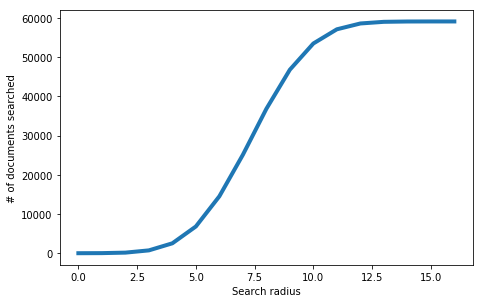

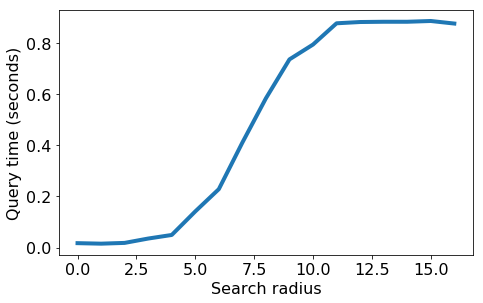

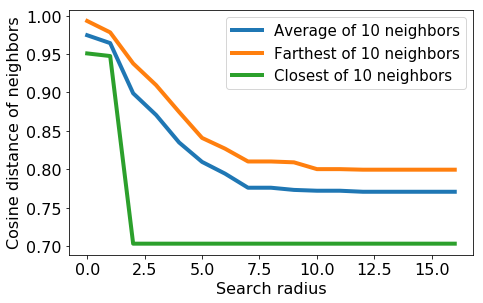

In [54]:
plt.figure(figsize=(7,4.5))
plt.plot(num_candidates_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('# of documents searched')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(query_time_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(average_distance_from_query_history, linewidth=4, label='Average of 10 neighbors')
plt.plot(max_distance_from_query_history, linewidth=4, label='Farthest of 10 neighbors')
plt.plot(min_distance_from_query_history, linewidth=4, label='Closest of 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance of neighbors')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [56]:

for i, v in enumerate(average_distance_from_query_history):
    if v <= 0.78:
        print i, v

7 0.775982605852
8 0.775982605852
9 0.773134987545
10 0.772070052412
11 0.772070052412
12 0.770719128949
13 0.770719128949
14 0.770719128949
15 0.770719128949
16 0.770719128949


In [57]:
def brute_force_query(vec, data, k):
    num_data_points = data.shape[0]
    
    # Compute distances for ALL data points in training set
    nearest_neighbors = graphlab.SFrame({'id':range(num_data_points)})
    nearest_neighbors['distance'] = pairwise_distances(data, vec, metric='cosine').flatten()
    
    return nearest_neighbors.topk('distance', k, reverse=True)

In [58]:
max_radius = 17
precision = {i:[] for i in xrange(max_radius)}
average_distance  = {i:[] for i in xrange(max_radius)}
query_time  = {i:[] for i in xrange(max_radius)}

np.random.seed(0)
num_queries = 10
for i, ix in enumerate(np.random.choice(corpus.shape[0], num_queries, replace=False)):
    print('%s / %s' % (i, num_queries))
    ground_truth = set(brute_force_query(corpus[ix,:], corpus, k=25)['id'])
    # Get the set of 25 true nearest neighbors
    
    for r in xrange(1,max_radius):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, k=10, max_search_radius=r)
        end = time.time()

        query_time[r].append(end-start)
        # precision = (# of neighbors both in result and ground_truth)/10.0
        precision[r].append(len(set(result['id']) & ground_truth)/10.0)
        average_distance[r].append(result['distance'][1:].mean())

0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10


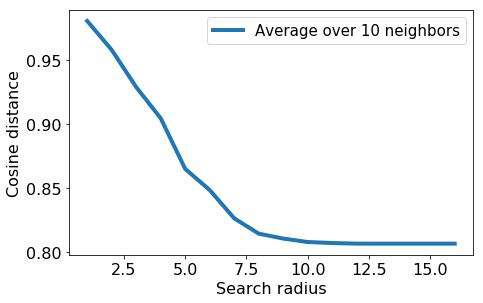

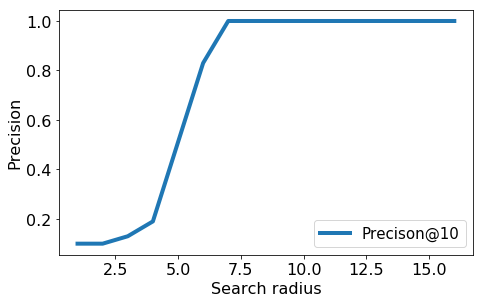

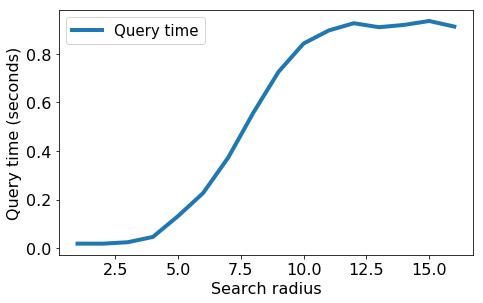

In [59]:
plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(average_distance[i]) for i in xrange(1,17)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(precision[i]) for i in xrange(1,17)], linewidth=4, label='Precison@10')
plt.xlabel('Search radius')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(query_time[i]) for i in xrange(1,17)], linewidth=4, label='Query time')
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [60]:
precision = {i:[] for i in xrange(5,20)}
average_distance  = {i:[] for i in xrange(5,20)}
query_time = {i:[] for i in xrange(5,20)}
num_candidates_history = {i:[] for i in xrange(5,20)}
ground_truth = {}

np.random.seed(0)
num_queries = 10
docs = np.random.choice(corpus.shape[0], num_queries, replace=False)

for i, ix in enumerate(docs):
    ground_truth[ix] = set(brute_force_query(corpus[ix,:], corpus, k=25)['id'])
    # Get the set of 25 true nearest neighbors

for num_vector in xrange(5,20):
    print('num_vector = %s' % (num_vector))
    model = train_lsh(corpus, num_vector, seed=143)
    
    for i, ix in enumerate(docs):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, k=10, max_search_radius=3)
        end = time.time()
        
        query_time[num_vector].append(end-start)
        precision[num_vector].append(len(set(result['id']) & ground_truth[ix])/10.0)
        average_distance[num_vector].append(result['distance'][1:].mean())
        num_candidates_history[num_vector].append(num_candidates)

num_vector = 5
num_vector = 6
num_vector = 7
num_vector = 8
num_vector = 9
num_vector = 10
num_vector = 11
num_vector = 12
num_vector = 13
num_vector = 14
num_vector = 15
num_vector = 16
num_vector = 17
num_vector = 18
num_vector = 19


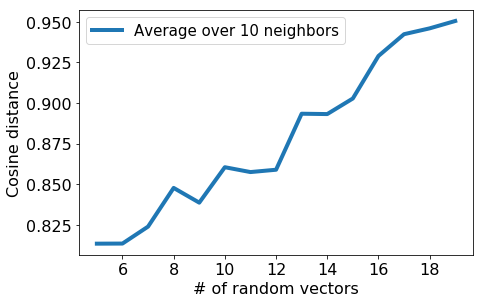

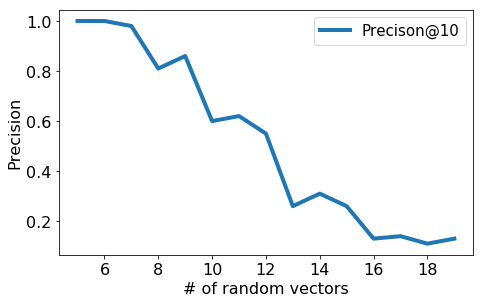

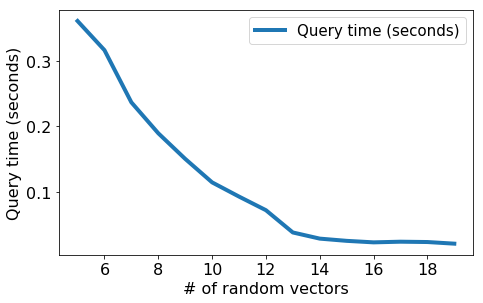

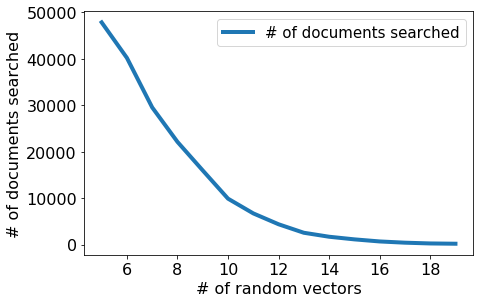

In [61]:
plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(average_distance[i]) for i in xrange(5,20)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('# of random vectors')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(precision[i]) for i in xrange(5,20)], linewidth=4, label='Precison@10')
plt.xlabel('# of random vectors')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(query_time[i]) for i in xrange(5,20)], linewidth=4, label='Query time (seconds)')
plt.xlabel('# of random vectors')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(num_candidates_history[i]) for i in xrange(5,20)], linewidth=4,
         label='# of documents searched')
plt.xlabel('# of random vectors')
plt.ylabel('# of documents searched')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()